In [31]:
import pandas as pd
import numpy as np
import ast
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC

from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

from tqdm import tqdm

from utils.FeatureTransformer import ADRThirdQuartileDeviationTransformer
from utils.preprocessor import preprocessor
import warnings
warnings.filterwarnings('ignore')


In [32]:
df = pd.read_csv('../Dataset/df_cleaned.csv')

print("Shape:", df.shape)

df.info()

Shape: (119205, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119205 entries, 0 to 119204
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119205 non-null  int64  
 1   LeadTime                     119205 non-null  int64  
 2   ArrivalDateYear              119205 non-null  int64  
 3   ArrivalDateMonth             119205 non-null  object 
 4   ArrivalDateWeekNumber        119205 non-null  int64  
 5   ArrivalDateDayOfMonth        119205 non-null  int64  
 6   StaysInWeekendNights         119205 non-null  int64  
 7   StaysInWeekNights            119205 non-null  int64  
 8   Adults                       119205 non-null  int64  
 9   Children                     119205 non-null  float64
 10  Babies                       119205 non-null  int64  
 11  Meal                         119205 non-null  object 
 12  MarketSegment                119205 no

## Convenience Splitting

In [33]:
def convenient_split_data(data, test_size=0.25, random_state=42):
    data = data.copy()

    
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    month_map = {month: f"{i:02d}" for i, month in enumerate(month_order, 1)}
    data['MonthNum'] = data['ArrivalDateMonth'].map(month_map)

    
    data['YearMonth'] = data['ArrivalDateYear'].astype(str) + '-' + data['MonthNum']

    
    data = data.sort_values(['ArrivalDateYear', 'MonthNum', 'ArrivalDateDayOfMonth'])

    
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

    for block in data['YearMonth'].unique():
        block_data = data[data['YearMonth'] == block]
        X_block = block_data.drop(columns=['IsCanceled', 'YearMonth', 'MonthNum'])
        y_block = block_data['IsCanceled']

        
        stratify = y_block if y_block.nunique() > 1 else None

        X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
            X_block, y_block, test_size=test_size, stratify=stratify, random_state=random_state
        )

        X_train_list.append(X_train_b)
        X_test_list.append(X_test_b)
        y_train_list.append(y_train_b)
        y_test_list.append(y_test_b)

    
    X_train = pd.concat(X_train_list).reset_index(drop=True)
    X_test = pd.concat(X_test_list).reset_index(drop=True)
    y_train = pd.concat(y_train_list).reset_index(drop=True)
    y_test = pd.concat(y_test_list).reset_index(drop=True)

    return X_train, X_test, y_train, y_test

X_cs_train, X_cs_test, y_cs_train, y_cs_test = convenient_split_data(df)





# Models Training

Models:   0%|          | 0/8 [00:00<?, ?it/s]


Training and evaluating: Logistic Regression


Models:  12%|█▎        | 1/8 [01:51<12:58, 111.20s/it]


Training and evaluating: Random Forest


Models:  25%|██▌       | 2/8 [04:14<12:59, 129.89s/it]


Training and evaluating: XGBoost


Models:  38%|███▊      | 3/8 [06:05<10:07, 121.56s/it]


Training and evaluating: LightGBM


[LightGBM] [Info] Number of positive: 45001, number of negative: 45001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 90002, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[LightGBM] [Info] Number of positive: 45001, number of negative: 45001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 90002, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[LightGBM] [Info] Number of positive: 45002, number of negative: 45002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1082
[LightGBM] [Info] Number of data points in the train set: 90004, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[LightGBM] [Info] Number of positive: 45002, number of negative: 45002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 90004, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[LightGBM] [Info] Number of positive: 45002, number of negative: 45002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 90004, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Models:  50%|█████     | 4/8 [07:57<07:50, 117.72s/it]


Training and evaluating: CatBoost


Models:  62%|██████▎   | 5/8 [10:24<06:24, 128.23s/it]


Training and evaluating: AdaBoost


Models:  75%|███████▌  | 6/8 [12:25<04:11, 125.79s/it]


Training and evaluating: Decision Tree


Models:  88%|████████▊ | 7/8 [14:14<02:00, 120.40s/it]


Training and evaluating: KNN


Models: 100%|██████████| 8/8 [16:11<00:00, 121.41s/it]


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Regression,0.789,0.720,0.704,0.712,0.846
Random Forest,0.841,0.793,0.772,0.782,0.908
XGBoost,0.829,0.780,0.750,0.765,0.896
LightGBM,0.826,0.779,0.740,0.759,0.891
CatBoost,0.832,0.786,0.750,0.768,0.897
AdaBoost,0.793,0.728,0.706,0.717,0.859
Decision Tree,0.796,0.709,0.763,0.735,0.792
KNN,0.807,0.738,0.742,0.740,0.862


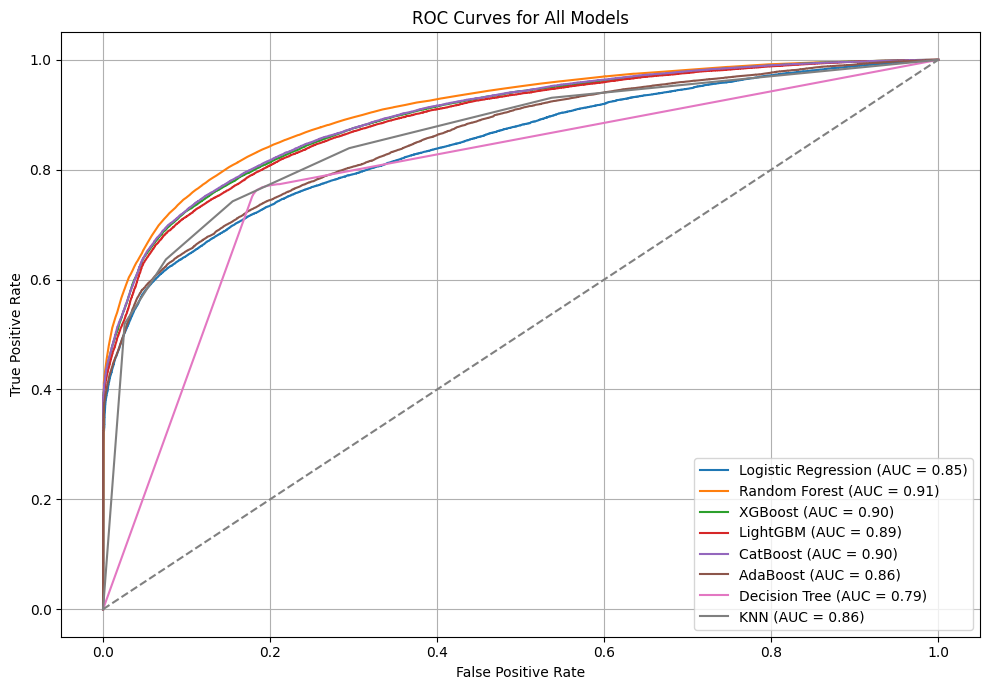

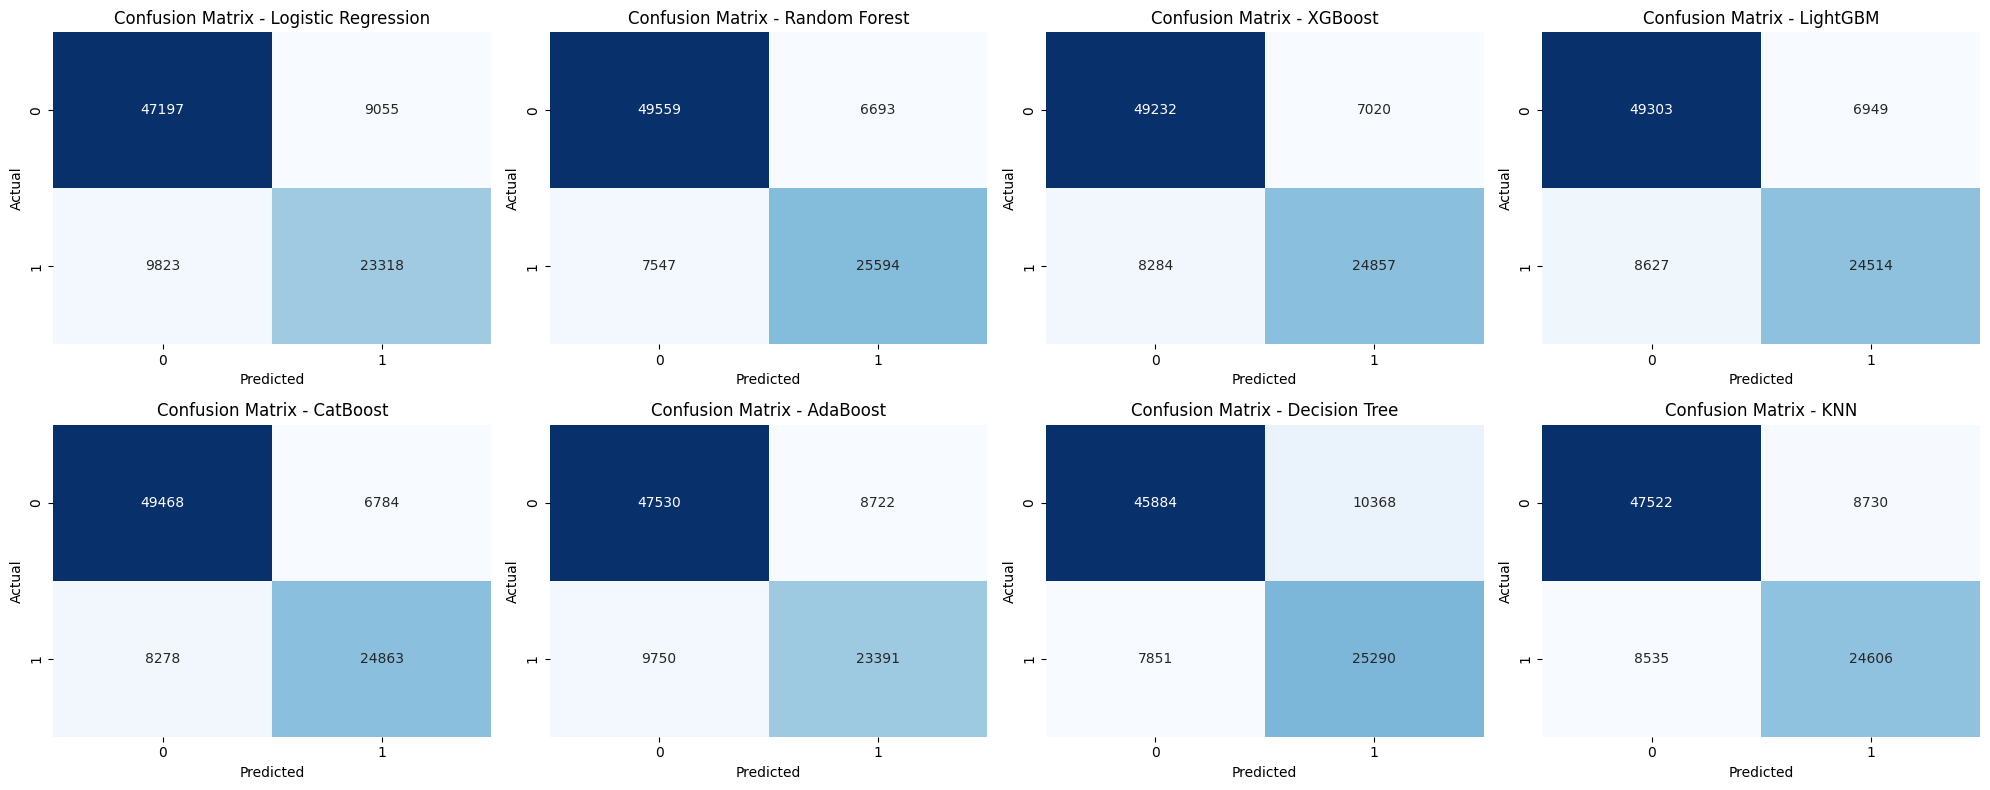

In [34]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_folds = list(skf.split(X_cs_train, y_cs_train))


results = []
roc_curves = {}
conf_matrices = {}


for name, model in tqdm(models.items(), desc="Models", total=len(models)):
    print(f"\nTraining and evaluating: {name}")

    pipeline = Pipeline([
        ('feature_eng', ADRThirdQuartileDeviationTransformer()),
        ('oversampling', SMOTENC(['Meal', 'MarketSegment', 'DistributionChannel',
                                  'DepositType', 'CustomerType', 'HotelType',
                                  'Agent', 'Company', 'IsRepeatedGuest'],
                                 random_state=42)),
        ('preproc', preprocessor),
        ('clf', model)
    ])

    y_true_all, y_pred_all, y_prob_all = [], [], []

   
    for train_idx, test_idx in tqdm(cv_folds, desc=f"CV Fold - {name}", leave=False):
        X_train, X_test = X_cs_train.iloc[train_idx], X_cs_train.iloc[test_idx]
        y_train, y_test = y_cs_train.iloc[train_idx], y_cs_train.iloc[test_idx]

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)

 
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_prob_all = np.array(y_prob_all)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_true_all, y_pred_all),
        'Precision': precision_score(y_true_all, y_pred_all, zero_division=0),
        'Recall': recall_score(y_true_all, y_pred_all),
        'F1 Score': f1_score(y_true_all, y_pred_all),
        'ROC AUC': roc_auc_score(y_true_all, y_prob_all)
    })

    conf_matrices[name] = confusion_matrix(y_true_all, y_pred_all)
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    roc_curves[name] = (fpr, tpr, roc_auc_score(y_true_all, y_prob_all))


df_results = pd.DataFrame(results).set_index("Model").round(3)
display(df_results)


df_results.to_csv("default_training.csv", index=True, encoding="utf-8")

# ROC Curve
plt.figure(figsize=(10, 7))
for name, (fpr, tpr, auc_score) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrices
cols = 4
rows = (len(models) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()

for idx, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'Confusion Matrix - {name}')
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Models (No SMOTENC):  38%|███▊      | 3/8 [00:30<00:48,  9.73s/it]


[LightGBM] [Info] Number of positive: 26513, number of negative: 45001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 71514, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370739 -> initscore=-0.529050
[LightGBM] [Info] Start training from score -0.529050


CV Fold - LightGBM:  20%|██        | 1/5 [00:00<00:01,  2.68it/s]


[LightGBM] [Info] Number of positive: 26513, number of negative: 45001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 820
[LightGBM] [Info] Number of data points in the train set: 71514, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370739 -> initscore=-0.529050
[LightGBM] [Info] Start training from score -0.529050


CV Fold - LightGBM:  40%|████      | 2/5 [00:00<00:01,  2.54it/s]


[LightGBM] [Info] Number of positive: 26512, number of negative: 45002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 821
[LightGBM] [Info] Number of data points in the train set: 71514, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370725 -> initscore=-0.529109
[LightGBM] [Info] Start training from score -0.529109


CV Fold - LightGBM:  60%|██████    | 3/5 [00:01<00:00,  2.52it/s]


[LightGBM] [Info] Number of positive: 26513, number of negative: 45002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 820
[LightGBM] [Info] Number of data points in the train set: 71515, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370733 -> initscore=-0.529072
[LightGBM] [Info] Start training from score -0.529072


CV Fold - LightGBM:  80%|████████  | 4/5 [00:01<00:00,  2.50it/s]


[LightGBM] [Info] Number of positive: 26513, number of negative: 45002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 71515, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370733 -> initscore=-0.529072
[LightGBM] [Info] Start training from score -0.529072


Models (No SMOTENC): 100%|██████████| 8/8 [01:31<00:00, 11.40s/it][A



=== Metriche di valutazione (Baseline) ===
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Model                                                                 
Logistic Regression  0.813554   0.838971  0.615159  0.709841  0.847239
Random Forest        0.848120   0.836429  0.733834  0.781780  0.909027
XGBoost              0.839294   0.853591  0.683806  0.759323  0.898926
LightGBM             0.836464   0.866598  0.660571  0.749688  0.894228
CatBoost             0.840234   0.860111  0.679581  0.759262  0.899363
AdaBoost             0.815981   0.849843  0.611720  0.711383  0.861155
Decision Tree        0.802647   0.730578  0.740895  0.735700  0.792464
KNN                  0.817670   0.789342  0.693190  0.738148  0.862408


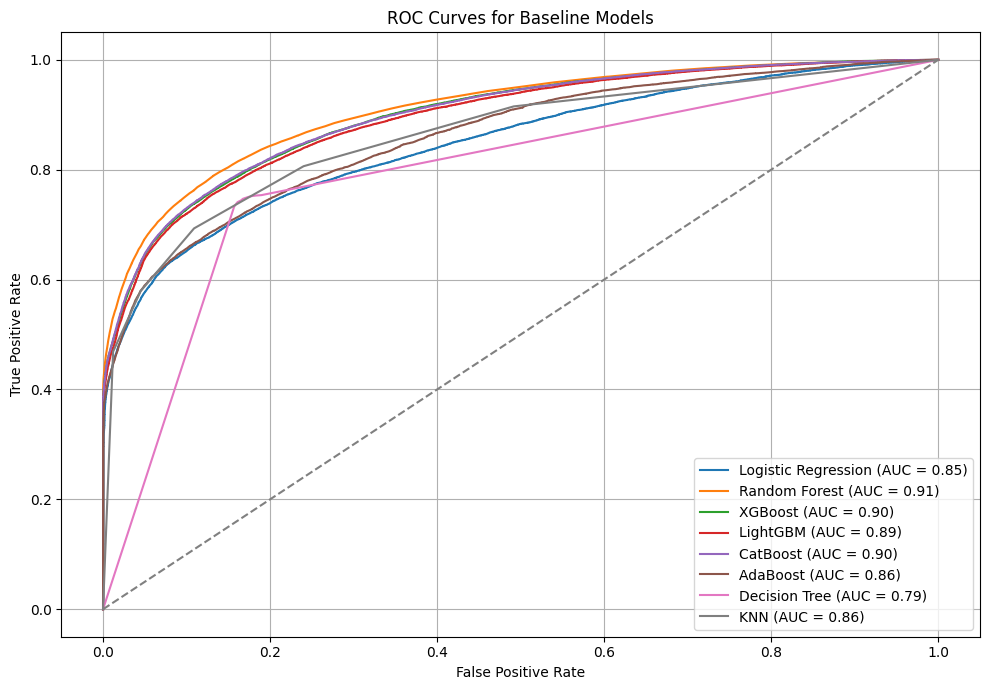

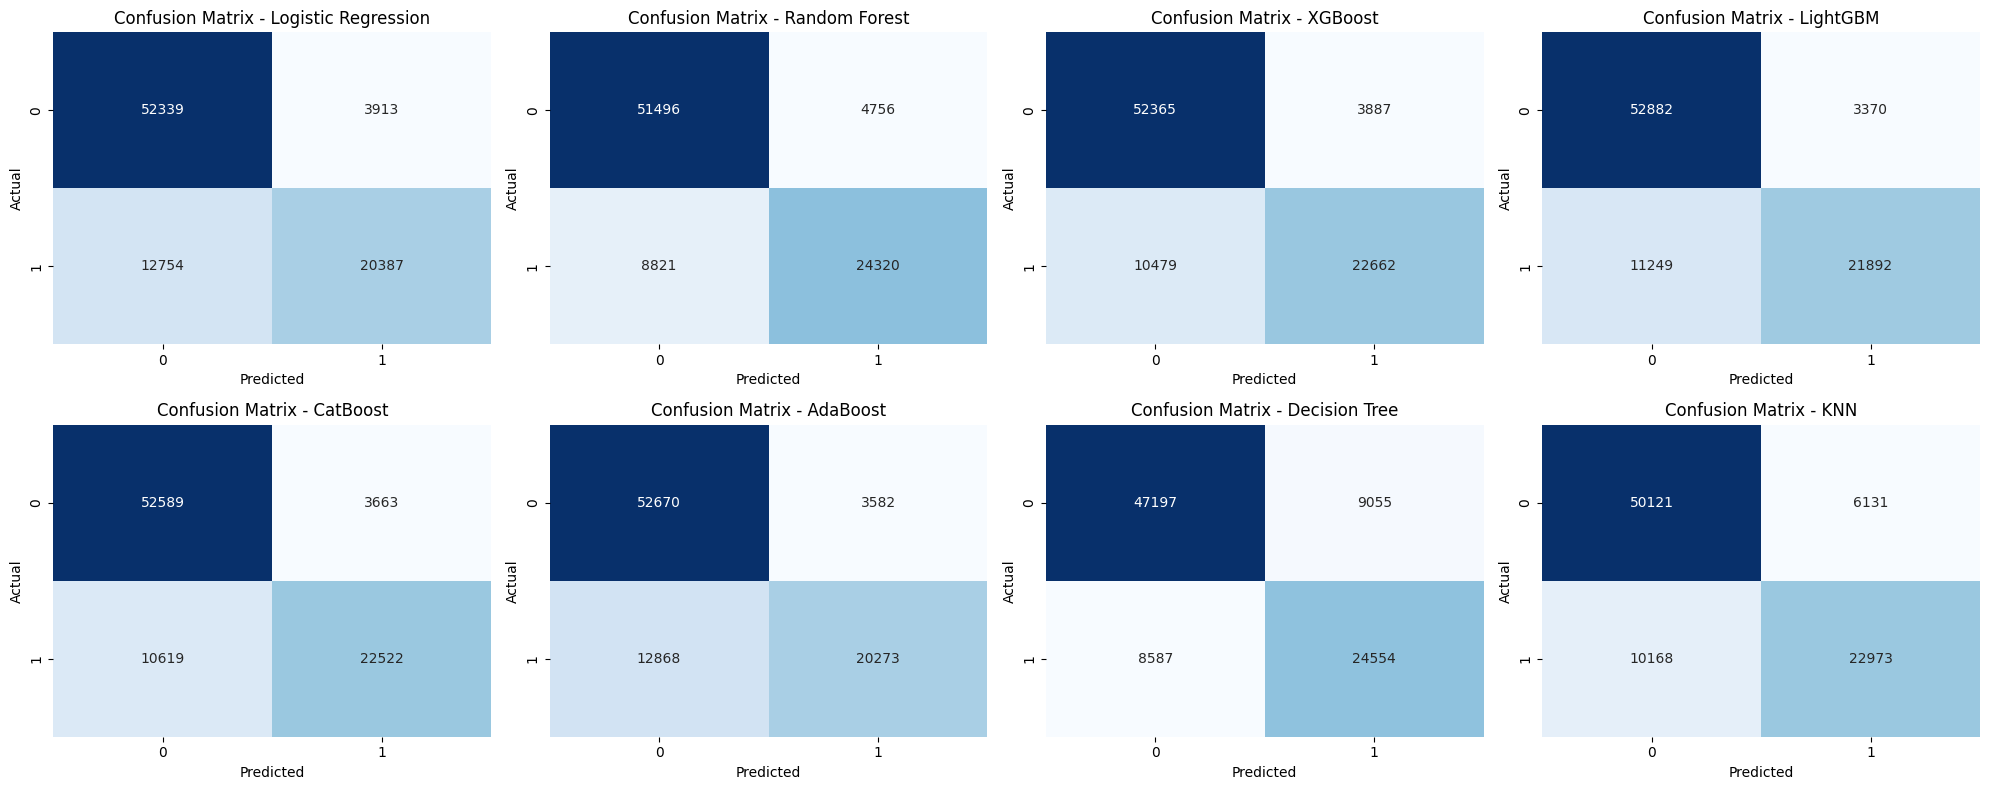

In [35]:
results_baseline = []
roc_curves_baseline = {}
conf_matrices_baseline = {}

for name, model in tqdm(models.items(), desc="Models (No SMOTENC)", total=len(models)):
    pipeline = Pipeline([
        ('feature_eng', ADRThirdQuartileDeviationTransformer()),
        ('preproc', preprocessor),
        ('clf', model)
    ])

    y_true_all, y_pred_all, y_prob_all = [], [], []
    for train_idx, test_idx in tqdm(cv_folds, desc=f"CV Fold - {name}", leave=False):
        X_train, X_test = X_cs_train.iloc[train_idx], X_cs_train.iloc[test_idx]
        y_train, y_test = y_cs_train.iloc[train_idx], y_cs_train.iloc[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_prob_all = np.array(y_prob_all)

    results_baseline.append({
        'Model': name,
        'Accuracy': accuracy_score(y_true_all, y_pred_all),
        'Precision': precision_score(y_true_all, y_pred_all, zero_division=0),
        'Recall': recall_score(y_true_all, y_pred_all),
        'F1 Score': f1_score(y_true_all, y_pred_all),
        'ROC AUC': roc_auc_score(y_true_all, y_prob_all)
    })

    conf_matrices_baseline[name] = confusion_matrix(y_true_all, y_pred_all)
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    roc_curves_baseline[name] = (fpr, tpr, roc_auc_score(y_true_all, y_prob_all))

df_metrics = pd.DataFrame(results_baseline).set_index('Model')
print("\n=== Metriche di valutazione (Baseline) ===")
print(df_metrics)

plt.figure(figsize=(10, 7))
for name, (fpr, tpr, auc_score) in roc_curves_baseline.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves for Baseline Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

cols = 4
rows = (len(conf_matrices_baseline) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()

for idx, (name, cm) in enumerate(conf_matrices_baseline.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'Confusion Matrix - {name}')
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

for j in range(len(conf_matrices_baseline), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [36]:
df_baseline = pd.DataFrame(results_baseline).set_index("Model").round(3)
df_with_smote = pd.DataFrame(results).set_index("Model").round(3)

display(df_with_smote.style.set_caption("With SMOTENC"))
display(df_baseline.style.set_caption("Without SMOTENC"))

comparison = df_with_smote - df_baseline
display(comparison.style.set_caption("Difference (With SMOTENC - Baseline)"))


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Regression,0.789000,0.720000,0.704000,0.712000,0.846000
Random Forest,0.841000,0.793000,0.772000,0.782000,0.908000
XGBoost,0.829000,0.780000,0.750000,0.765000,0.896000
LightGBM,0.826000,0.779000,0.740000,0.759000,0.891000
CatBoost,0.832000,0.786000,0.750000,0.768000,0.897000
AdaBoost,0.793000,0.728000,0.706000,0.717000,0.859000
Decision Tree,0.796000,0.709000,0.763000,0.735000,0.792000
KNN,0.807000,0.738000,0.742000,0.740000,0.862000


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Regression,0.814000,0.839000,0.615000,0.710000,0.847000
Random Forest,0.848000,0.836000,0.734000,0.782000,0.909000
XGBoost,0.839000,0.854000,0.684000,0.759000,0.899000
LightGBM,0.836000,0.867000,0.661000,0.750000,0.894000
CatBoost,0.840000,0.860000,0.680000,0.759000,0.899000
AdaBoost,0.816000,0.850000,0.612000,0.711000,0.861000
Decision Tree,0.803000,0.731000,0.741000,0.736000,0.792000
KNN,0.818000,0.789000,0.693000,0.738000,0.862000


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Regression,-0.025000,-0.119000,0.089000,0.002000,-0.001000
Random Forest,-0.007000,-0.043000,0.038000,0.000000,-0.001000
XGBoost,-0.010000,-0.074000,0.066000,0.006000,-0.003000
LightGBM,-0.010000,-0.088000,0.079000,0.009000,-0.003000
CatBoost,-0.008000,-0.074000,0.070000,0.009000,-0.002000
AdaBoost,-0.023000,-0.122000,0.094000,0.006000,-0.002000
Decision Tree,-0.007000,-0.022000,0.022000,-0.001000,0.000000
KNN,-0.011000,-0.051000,0.049000,0.002000,0.000000


In [ ]:
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs', 'liblinear']
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__max_features': ['sqrt', 'log2'],
        'clf__min_samples_split': [2, 5, 10]
    }),
    'AdaBoost': (AdaBoostClassifier(random_state=42), {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 1.0]
    }),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__criterion': ['gini', 'entropy']
    }),
    'KNN': (KNeighborsClassifier(), {
        'clf__n_neighbors': [3, 5, 7, 9],
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2]  # Manhattan (1) e Euclidean (2)
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [3, 5, 7],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.8, 1.0]
    }),
    'LightGBM': (LGBMClassifier(random_state=42), {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [-1, 10, 20],
        'clf__learning_rate': [0.01, 0.1],
        'clf__num_leaves': [31, 50, 100],
        'clf__subsample': [0.8, 1.0]
    }),
    'CatBoost': (CatBoostClassifier(verbose=0, random_state=42), {
        'clf__iterations': [100, 200],
        'clf__depth': [4, 6, 8],
        'clf__learning_rate': [0.01, 0.1],
        'clf__l2_leaf_reg': [1, 3, 5]
    })
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


results = []


# Loop Grid Search
for name, (model, param_grid) in models.items():
    print(f"\n Starting GridSearchCV for: {name}")

    pipeline = Pipeline([
        ('feature_eng', ADRThirdQuartileDeviationTransformer()),
        ('oversampling', SMOTENC(['Meal', 'MarketSegment', 'DistributionChannel',
                                  'DepositType', 'CustomerType', 'HotelType', 'Agent', 'Company','IsRepeatedGuest'],random_state=42),),
        ('preproc', preprocessor),
        ('clf', model)
    ])


    grid_search = GridSearchCV(pipeline, param_grid, scoring="f1",
                                   cv=cv_folds, n_jobs=-1, verbose=2)
    grid_search.fit(X_cs_train, y_cs_train)

    results.append({
            'Model': name,
            'Best_score': grid_search.best_score_,
            'Best Params': grid_search.best_params_,
            'F1': grid_search.best_score_
        })

    print(f"Best CV F1: {grid_search.best_score_:.4f}")
    print(f"Best params: {grid_search.best_params_}")



results_df = pd.DataFrame(results)
results_df.to_csv("grid_search_results.csv", index=False)



 Starting GridSearchCV for: Logistic Regression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CV F1: 0.7115
Best params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

 Starting GridSearchCV for: Random Forest
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best CV F1: 0.7865
Best params: {'clf__max_depth': 30, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 2, 'clf__n_estimators': 300}

 Starting GridSearchCV for: AdaBoost
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best CV F1: 0.7202
Best params: {'clf__learning_rate': 1.0, 'clf__n_estimators': 200}

 Starting GridSearchCV for: Decision Tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV F1: 0.7474
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__min_samples_split': 2}

 Starting GridSearchCV for: KNN
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best CV F1: 0.7645
Best params: {'clf__n_neighbors': 9

In [37]:
grid_results = pd.read_csv("grid_search_results.csv")
default_results_df = pd.read_csv("default_training.csv")


default_results_df = df_results.reset_index()[['Model', 'F1 Score']].rename(columns={'F1 Score': 'Default F1'})


comparison_df = pd.merge(grid_results, default_results_df, on='Model')
comparison_df['F1 Improvement'] = comparison_df['F1'] - comparison_df['Default F1']
comparison_df = comparison_df.sort_values(by='F1 Improvement', ascending=False)

comparison_df['Chosen Version'] = comparison_df.apply(
    lambda row: 'Optimized' if row['F1 Improvement'] > 0 else 'Default', axis=1
)

model_selection = comparison_df.set_index('Model')['Chosen Version'].to_dict()


pd.Series(model_selection).to_csv("best_model_versions.csv", header=['Chosen Version'])


In [38]:
comparison_df

,Model,Best_score,Best Params,F1,Default F1,F1 Improvement,Chosen Version
4,KNN,0.764453,"{'clf__n_neighbors': 9, 'clf__p': 1, 'clf__wei...",0.764453,0.740,0.024453,Optimized
6,LightGBM,0.775104,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.775104,0.759,0.016104,Optimized
3,Decision Tree,0.747445,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.747445,0.735,0.012445,Optimized
5,XGBoost,0.771616,"{'clf__colsample_bytree': 1.0, 'clf__learning_...",0.771616,0.765,0.006616,Optimized
1,Random Forest,0.786476,"{'clf__max_depth': 30, 'clf__max_features': 's...",0.786476,0.782,0.004476,Optimized
2,AdaBoost,0.720229,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",0.720229,0.717,0.003229,Optimized
0,Logistic Regression,0.711549,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv...",0.711549,0.712,-0.000451,Default
7,CatBoost,0.762803,"{'clf__depth': 8, 'clf__iterations': 200, 'clf...",0.762803,0.768,-0.005197,Default



 Cross-validation for: Logistic Regression

 Cross-validation for: Random Forest

 Cross-validation for: XGBoost

 Cross-validation for: LightGBM
[LightGBM] [Info] Number of positive: 45001, number of negative: 45001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 90002, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 45001, number of negative: 45001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] N

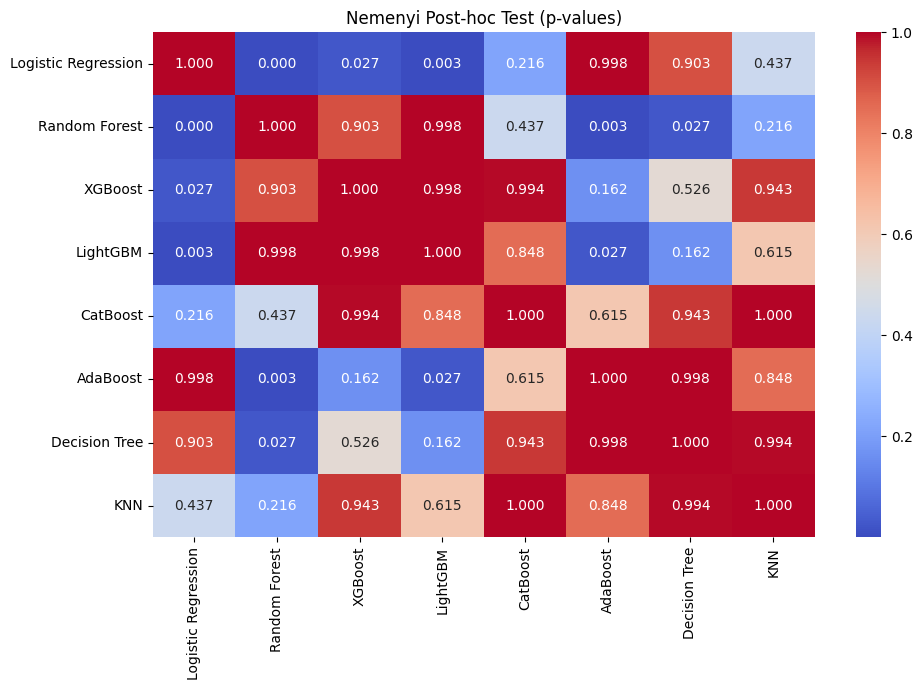

In [ ]:
model_selection = pd.read_csv("best_model_versions.csv", index_col=0).squeeze().to_dict()
grid_df = pd.read_csv("grid_search_results.csv")


f1_scores = {}


for name, model_tuple in models.items():
    print(f"\n Cross-validation for: {name}")
    
   
    base_model = model_tuple[0] if isinstance(model_tuple, tuple) else model_tuple

    
    version = model_selection.get(name, 'Default')
    if version == 'Optimized':
        row = grid_df[grid_df['Model'] == name].iloc[0]
        best_params = ast.literal_eval(row['Best Params']) if row['Best Params'] != 'Default' else {}
    else:
        best_params = {}

    f1s = []

    
    for train_idx, test_idx in cv_folds:
        X_train_fold = X_cs_train.iloc[train_idx]
        X_test_fold = X_cs_train.iloc[test_idx]
        y_train_fold = y_cs_train.iloc[train_idx]
        y_test_fold = y_cs_train.iloc[test_idx]

        pipeline = Pipeline([
            ('feature_eng', ADRThirdQuartileDeviationTransformer()),
            ('oversample', SMOTENC(categorical_features=['Meal', 'MarketSegment', 'DistributionChannel',
                        'DepositType', 'CustomerType', 'HotelType', 
                        'Agent', 'Company', 'IsRepeatedGuest'], random_state=42)),
            ('preproc', preprocessor),
            ('clf', base_model)
        ])
        pipeline.set_params(**best_params)
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_fold = pipeline.predict(X_test_fold)
        f1s.append(f1_score(y_test_fold, y_pred_fold))

    f1_scores[name] = f1s


f1_df = pd.DataFrame(f1_scores)
print("\n F1 for fold:")
print(f1_df.round(3))


stat, p = friedmanchisquare(*[f1_df[col] for col in f1_df.columns])
print(f"\n Friedman statistic = {stat:.4f}, p-value = {p:.4f}")


if p < 0.05:
    nemenyi = sp.posthoc_nemenyi_friedman(f1_df.values)
    nemenyi.columns = f1_df.columns
    nemenyi.index = f1_df.columns

    print("\n Nemenyi post-hoc test (p-values):")
    print(nemenyi.round(4))

    # Heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(nemenyi, annot=True, fmt=".3f", cmap='coolwarm')
    plt.title("Nemenyi Post-hoc Test (p-values)")
    plt.tight_layout()
    plt.show()
else:
    print(" No significative difference between models (p ≥ 0.05)")



Valutazione hold-out: Random Forest
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     18758
           1       0.79      0.78      0.79     11054

    accuracy                           0.84     29812
   macro avg       0.83      0.83      0.83     29812
weighted avg       0.84      0.84      0.84     29812


Valutazione hold-out: LightGBM
[LightGBM] [Info] Number of positive: 56252, number of negative: 56252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 112504, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.86      0.88      0.87  

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Random Forest,0.844,0.794,0.781,0.788,0.914
LightGBM,0.835,0.792,0.752,0.772,0.902
XGBoost,0.831,0.784,0.751,0.767,0.900
CatBoost,0.827,0.785,0.736,0.759,0.892
KNN,0.828,0.768,0.769,0.768,0.894


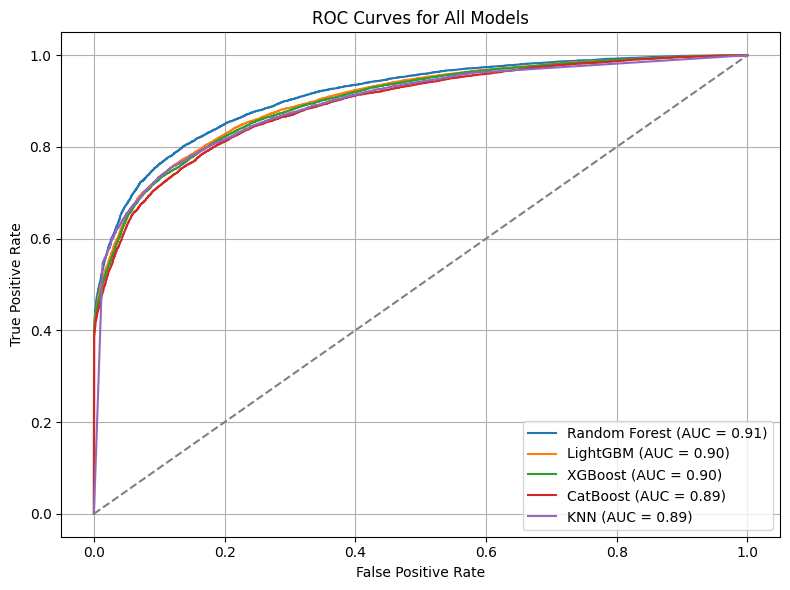

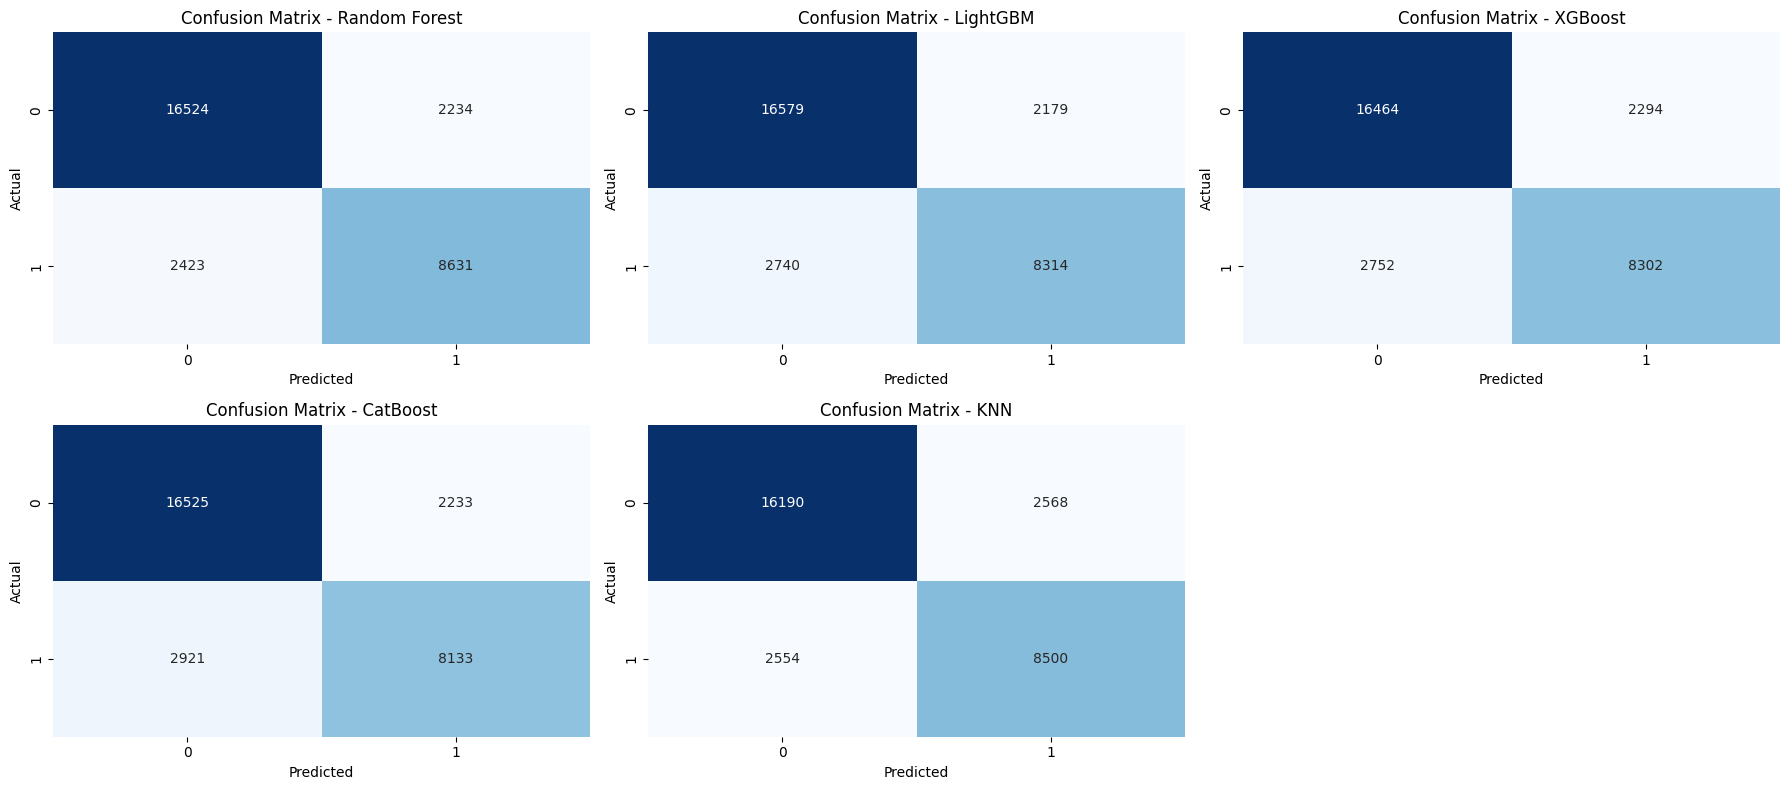

In [ ]:
def get_best_params(model_name):
    row = grid_df[grid_df['Model'] == model_name].iloc[0]
    if row['Best Params'] == 'Default':
        return {}
    raw_params = ast.literal_eval(row['Best Params'])
    return {k.replace("clf__", ""): v for k, v in raw_params.items()}


top_models = ['Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'KNN']

model_classes = {
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier,
    'LightGBM': LGBMClassifier,
    'CatBoost': CatBoostClassifier,
    'KNN': KNeighborsClassifier,
}


holdout_results = []
roc_data = {}
conf_matrices = {}


for name in top_models:
    print(f"\nValutazione hold-out: {name}")

    
    base_model = model_classes[name](**get_best_params(name))

    
    pipeline = Pipeline([
        ('feature_eng', ADRThirdQuartileDeviationTransformer()),
        ('oversample', SMOTENC(categorical_features=[
            'Meal', 'MarketSegment', 'DistributionChannel', 'DepositType',
            'CustomerType', 'HotelType', 'Agent', 'Company', 'IsRepeatedGuest'
        ], random_state=42)),
        ('preproc', preprocessor),
        ('clf', base_model)
    ])

    pipeline.fit(X_cs_train, y_cs_train)
    y_pred = pipeline.predict(X_cs_test)
    y_prob = pipeline.predict_proba(X_cs_test)[:, 1]

    
    acc = accuracy_score(y_cs_test, y_pred)
    prec = precision_score(y_cs_test, y_pred)
    rec = recall_score(y_cs_test, y_pred)
    f1 = f1_score(y_cs_test, y_pred)
    auc = roc_auc_score(y_cs_test, y_prob)

    holdout_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': auc
    })

    
    conf_matrices[name] = confusion_matrix(y_cs_test, y_pred)
    fpr, tpr, _ = roc_curve(y_cs_test, y_prob)
    roc_data[name] = (fpr, tpr, auc)

    
    print(classification_report(y_cs_test, y_pred))


results_df = pd.DataFrame(holdout_results).set_index("Model").round(3)
display(results_df)


results_df.to_csv("holdout_results.csv", index=True)

# ROC Curve plot
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrices
cols = 3
rows = (len(conf_matrices) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for idx, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix - {name}')
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")


for j in range(len(conf_matrices), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
X = df.drop(columns=["IsCanceled"])
y = df["IsCanceled"].astype(int)


grid_df = pd.read_csv("grid_search_results.csv")
best_row = grid_df[grid_df["Model"] == "Random Forest"].iloc[0]

if best_row["Best Params"] == "Default":
    best_params = {}
else:
    best_params = ast.literal_eval(best_row["Best Params"])
    best_params = {k.replace("clf__", ""): v for k, v in best_params.items()}


rf_model = RandomForestClassifier(**best_params, random_state=42)


categorical = X.select_dtypes(include=['object']).columns.tolist()
cat_indices = [X.columns.get_loc(c) for c in categorical]


pipeline = Pipeline([
        ('feature_eng', ADRThirdQuartileDeviationTransformer()),
        ('preproc', preprocessor),
        ('clf', rf_model)
    ])

pipeline.fit(X, y)

joblib.dump(pipeline, "hotel_pipeline.pkl")
print("✅ Pipeline salvata in hotel_pipeline.pkl")


✅ Pipeline salvata in hotel_pipeline.pkl
